## LDA Model Optimization

In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import spacy
import en_core_web_sm
import gensim
from unidecode import unidecode
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from gensim.utils import simple_preprocess
import spacy
import nltk
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases, Phraser
from collections import Counter
from gensim.corpora import Dictionary
from wordcloud import WordCloud
import plotly.express as px

In [44]:
df = pd.read_csv('../ui_customerchurn/data/coursera.csv')

In [45]:
df.head()

,Unnamed: 0,review,recommendation
0,0,"Great course - I recommend it for all, especia...",Recommended
1,1,One of the most useful course on IT Management!,Recommended
2,2,I was disappointed because the name is mislead...,Not Recommended
3,3,Super content. I'll definitely re-do the course,Recommended
4,4,One of the excellent courses at Coursera for i...,Recommended


In [46]:
df = df[df['recommendation'] == 'Not Recommended']

In [47]:
df.head()

,Unnamed: 0,review,recommendation
2,2,I was disappointed because the name is mislead...,Not Recommended
8,8,"Good content, but the course setting does (at ...",Not Recommended
12,12,This course does not say anything about digiti...,Not Recommended
14,14,"The course content is quite good, though it co...",Not Recommended
39,39,I'll start by saying that this course gives a ...,Not Recommended


In [48]:
def remove_punctuations(text):
    punctuations = string.punctuation
    for punctuation in punctuations:
        text = text.replace(punctuation, '')
    return text

def lowercase(text):
    text = text.lower() #str was removed
    return text

def remove_num(text):
    text = ''.join(word for word in text if not word.isdigit())
    text = unidecode(text)
    return text

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  # deacc=True removes punctuations

def data_words(text):
    data_clean = text['review_clean'].values.tolist() # change to review
    data_words_list = list(sent_to_words(data_clean))
    return data_words_list

stop_words = stopwords.words('english')
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    bigram = Phrases(texts, min_count=5, threshold=100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]


def lemmatization(texts,allowed_postags=['NOUN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def common_words_remover (texts):
    flat_list = [item for sublist in texts for item in sublist]
    common_words = [t[0] for t in Counter(flat_list).most_common(20)]
    stop_words.extend(common_words)
    texts = remove_stopwords(texts)
    texts = make_bigrams(texts)
    return texts

def model_params(texts):
    # Create Dictionary
    id2word = Dictionary(texts)
    # Create Corpus
    texts = texts
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    return id2word, corpus

def cleaner(df):

    df['review'] = df['review'].astype(str)
    df['review_clean'] = df['review'].apply(remove_punctuations).copy()
    df['review_clean'] = df['review_clean'].apply(lowercase)
    df['review_clean'] = df['review_clean'].apply(remove_num)
    df['review_clean'] = df['review_clean'].apply(unidecode)
    data_words_list = data_words(df)
    data_words_nostops = remove_stopwords(data_words_list)
    data_words_bigrams = make_bigrams(data_words_nostops)
    # Do lemmatization keeping only noun, adj
    data_lemmatized = lemmatization(data_words_bigrams,allowed_postags=['NOUN', 'ADJ'])
    data_lemmatized = common_words_remover(data_lemmatized)
    id2word,corpus = model_params(data_lemmatized)
    return id2word, corpus

In [49]:
# Build LDA model
def model(df,num_topics=5,chunksize=100):
    id2word,corpus = cleaner(df)
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=9,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
    return lda_model,corpus


In [50]:
%%time

lda_model,corpus = model(df)

CPU times: user 34.1 s, sys: 36.6 ms, total: 34.1 s
Wall time: 34.1 s


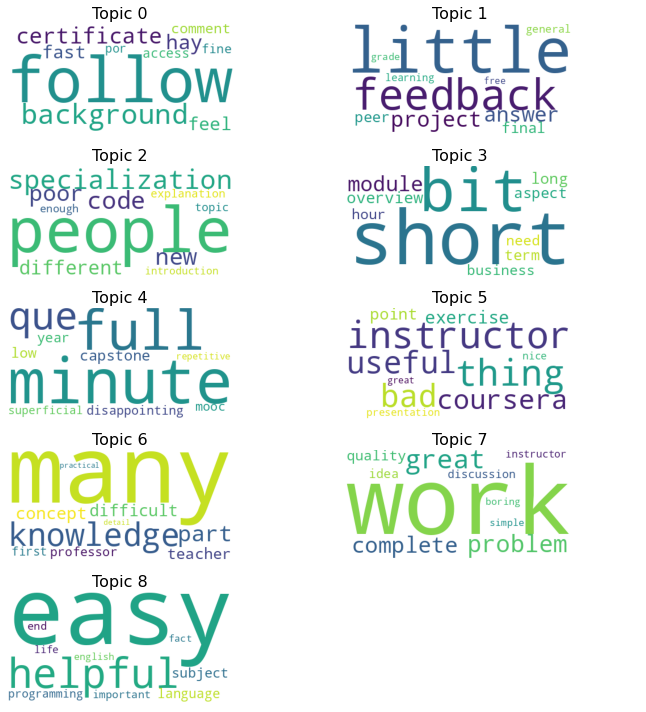

CPU times: user 919 ms, sys: 251 ms, total: 1.17 s
Wall time: 917 ms


In [49]:
%%time

# 1. Wordcloud of Top N words in each topic

cloud = WordCloud(background_color='white',
#                   width=2500,
#                   height=1800,
                  max_words=30,
                  contour_color='steelblue',
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i,topic in enumerate(topics):

    topic_words = dict(topic[1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    axes.flatten()[i].imshow(cloud)
    axes.flatten()[i].set_title('Topic ' + str(i), fontdict=dict(size=16))
    axes.flatten()[i].axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [11]:
lda_model.__dict__.keys()

dict_keys(['dtype', 'id2word', 'num_terms', 'distributed', 'num_topics', 'chunksize', 'decay', 'offset', 'minimum_probability', 'num_updates', 'passes', 'update_every', 'eval_every', 'minimum_phi_value', 'per_word_topics', 'callbacks', 'alpha', 'optimize_alpha', 'eta', 'optimize_eta', 'random_state', 'iterations', 'gamma_threshold', 'dispatcher', 'numworkers', 'state', 'expElogbeta', 'lifecycle_events'])

In [19]:
# Topic Highlighted Sentences
import random

highlight_probability_minimum = 0.001

def white_or_black_text(background_color):
    # https://stackoverflow.com/questions/3942878/how-to-decide-font-color-in-white-or-black-depending-on-background-color
    red = int(background_color[1:3], 16)
    green = int(background_color[3:5], 16)
    blue = int(background_color[5:], 16)
    return 'black' if (red * 0.299 + green * 0.587 + blue * 0.114) > 186 else 'white'


def highlighted_sentence(sample, model, highlight_probability_minimum):

    COLORS = [color for color in mcolors.XKCD_COLORS.values()]
    colors = random.sample(COLORS,9)  #k=model_kwargs['num_topics'] replace it with the number of topics

    for index, row in sample.iterrows():
        html_elements = []
        for token in row['review'].split():
            if model.id2word.token2id.get(token) is None:
                html_elements.append(
                    f'<span style="text-decoration:None;">{token}</span>'
                )
            else:
                term_topics = model.get_term_topics(
                    token, minimum_probability=0)
                topic_probabilities = [
                    term_topic[1] for term_topic in term_topics
                ]
                max_topic_probability = max(
                    topic_probabilities) if topic_probabilities else 0
                if max_topic_probability < highlight_probability_minimum:
                    html_elements.append(token)
                else:
                    max_topic_index = topic_probabilities.index(
                        max_topic_probability)
                    max_topic = term_topics[max_topic_index]
                    background_color = colors[max_topic[0]]
                    # color = 'white'
                    color = white_or_black_text(background_color)
                    html_elements.append(
                        f'<span style="background-color: {background_color}; color: {color}; opacity: 0.5;">{token}</span>'
                    )
                    print(f'Document #{sample.index}: {" ".join(html_elements)}')

sample = df.sample(10)
html_elements = highlighted_sentence(sample, lda_model, highlight_probability_minimum)



Document #Int64Index([61911, 20205, 10490, 30602, 47582, 46051, 105814, 92894, 1417,
            8196],
           dtype='int64'): <span style="text-decoration:None;">Very</span> <span style="text-decoration:None;">good</span> <span style="text-decoration:None;">and</span> simplified <span style="text-decoration:None;">instruction.</span> <span style="text-decoration:None;">But</span> <span style="text-decoration:None;">I</span> <span style="background-color: #fd5956; color: white; opacity: 0.5;">think</span>
Document #Int64Index([61911, 20205, 10490, 30602, 47582, 46051, 105814, 92894, 1417,
            8196],
           dtype='int64'): <span style="text-decoration:None;">Very</span> <span style="text-decoration:None;">good</span> <span style="text-decoration:None;">and</span> simplified <span style="text-decoration:None;">instruction.</span> <span style="text-decoration:None;">But</span> <span style="text-decoration:None;">I</span> <span style="background-color: #fd5956; color: white